## Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import time

from math import sqrt
from numpy import loadtxt
from itertools import product
from tqdm import tqdm
from sklearn import preprocessing
from xgboost import plot_tree
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_columns', 500)
pd.set_option("display.max_rows", 60)

# Part2
## Set up some global vars 

In [16]:

# Set seeds and options
np.random.seed(10)
pd.set_option('display.max_rows', 231)
pd.set_option('display.max_columns', 100)

    # Feature engineering list
new_features = []
enable_feature_idea = [True, True, True, True, True, True, True, True, True, True]

    # Some parameters(maybe add more periods, score will be better) [1,2,3,12]
lookback_range = [1,2,3,4,5,6,7,8,9,10]

tqdm.pandas()


## Load data

In [5]:
test_dataset = loadtxt('D:\\all\\test.csv', delimiter="," ,skiprows=1, usecols = (1,2), dtype=int)
testset = pd.DataFrame(test_dataset, columns = ['shop_id', 'item_id'])
testset.head()

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [6]:

current = time.time()

trainset = pd.read_csv('trainset_with_grid.csv')
#items = pd.read_csv('data/items.csv')
#shops = pd.read_csv('data/shops.csv')


    # Only use more recent data
start_month = 0
end_month = 33
trainset = trainset[['shop_id', 'item_id', 'item_category_id', 'date_block_num', 'item_price', 'item_cnt_month']]
trainset = trainset[(trainset.date_block_num >= start_month) & (trainset.date_block_num <= end_month)]

print('Loading test set...')
test_dataset = loadtxt('D:\\all\\test.csv', delimiter="," ,skiprows=1, usecols = (1,2), dtype=int)
testset = pd.DataFrame(test_dataset, columns = ['shop_id', 'item_id'])

print('Merging with other datasets...')
    # Get item category id into test_df
testset = testset.merge(items[['item_id', 'item_category_id']], on = 'item_id', how = 'left')
testset['date_block_num'] = 34
    # Make testset contains same column as trainset so we can concatenate them row-wise
testset['item_cnt_month'] = -1

train_test_set = pd.concat([trainset, testset], axis = 0) 

end = time.time()
diff = end - current
print('Took ' + str(int(diff)) + ' seconds to train and predict val set')

Loading test set...
Merging with other datasets...
Took 8 seconds to train and predict val set


## Fix category

In [7]:
l_cat = list(item_categories.item_category_name)
l_cat[0] = 'PC Headsets'
for i in range (1,8):
    l_cat[i]="Access"
l_cat[8] = 'Tickets'
l_cat[9] = 'Delivery'
for ind in range(10,18):
    l_cat[ind] = 'Consoles'
for ind in range(18,25):
    l_cat[ind] = 'Console Games'
l_cat[25] = 'Accessories for games'
for ind in range(26,28):
    l_cat[ind] = 'phone games'
for ind in range(28,32):
    l_cat[ind] = 'CD games'
for ind in range(32,37):
    l_cat[ind] = 'Card'
for ind in range(37,43):
    l_cat[ind] = 'Movie'
for ind in range(43,55):
    l_cat[ind] = 'Books'
for ind in range(55,61):
    l_cat[ind] = 'Music'
for ind in range(61,73):
    l_cat[ind] = 'Gifts'
for ind in range(73,79):
    l_cat[ind] = 'Soft'
for ind in range(79,81):
    l_cat[ind] = 'Office'
for ind in range(81,83):
    l_cat[ind] = 'Clean'
l_cat[83] = 'Elements of a food'

In [8]:
lb = preprocessing.LabelEncoder()
item_categories['item_category_id_fix'] = lb.fit_transform(l_cat)
item_categories['item_category_name_fix'] = l_cat
item_categories.head()

,item_category_name,item_category_id,item_category_id_fix,item_category_name_fix
0,PC - Гарнитуры/Наушники,0,14,PC Headsets
1,Аксессуары - PS2,1,0,Access
2,Аксессуары - PS3,2,0,Access
3,Аксессуары - PS4,3,0,Access
4,Аксессуары - PSP,4,0,Access


In [9]:
train_test_set = train_test_set.merge(item_categories[['item_category_id', 'item_category_id_fix']], on = 'item_category_id', how = 'left')
_ = train_test_set.drop(['item_category_id'],axis=1, inplace=True)
train_test_set.rename(columns = {'item_category_id_fix':'item_category_id'}, inplace = True)

_ = item_categories.drop(['item_category_id'],axis=1, inplace=True)
_ = item_categories.drop(['item_category_name'],axis=1, inplace=True)


item_categories.rename(columns = {'item_category_id_fix':'item_category_id'}, inplace = True)
item_categories.rename(columns = {'item_category_name_fix':'item_category_name'}, inplace = True)
item_categories = item_categories.drop_duplicates()
item_categories.index = np.arange(0, len(item_categories))


In [10]:
train_test_set=train_test_set.drop("item_price", axis=1)
train_test_set.head()

,date_block_num,item_cnt_month,item_id,shop_id,item_category_id
0,0,1.0,22154,59,11
1,0,5.0,22154,25,11
2,0,1.0,22154,24,11
3,0,0.0,22154,19,11
4,0,0.0,22154,22,11


## Add city 

In [11]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [13]:
lb1=preprocessing.LabelEncoder()
shops["city"]=shops["shop_name"].map(lambda x: str(x).split()[0])

shops["city_id"]=lb1.fit_transform(shops.city)

In [14]:
train_test_set=train_test_set.merge(shops[["shop_id", "city_id"]], how="left", on="shop_id")

In [15]:
train_test_set.head()

,date_block_num,item_cnt_month,item_id,shop_id,item_category_id,city_id
0,0,1.0,22154,59,11,31
1,0,5.0,22154,25,11,14
2,0,1.0,22154,24,11,14
3,0,0.0,22154,19,11,13
4,0,0.0,22154,22,11,14


In [49]:
train_test_set.isna().sum()

date_block_num      0
item_cnt_month      0
item_id             0
shop_id             0
item_category_id    0
city_id             0
dtype: int64

# Idea 0: Add previous shop/item sales as feature (Lag feature)

In [17]:

if enable_feature_idea[0]:
    for diff in tqdm(lookback_range):
        feature_name = 'prev_shopitem_sales_' + str(diff)
        trainset2 = train_test_set.copy()
        trainset2.loc[:, 'date_block_num'] += diff
        trainset2.rename(columns={'item_cnt_month': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(trainset2[['shop_id', 'item_id', 'date_block_num', feature_name]], on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name].fillna(0)
        new_features.append(feature_name)
train_test_set.head(3)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  7.66s/it]


,date_block_num,item_cnt_month,item_id,shop_id,item_category_id,city_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_4,prev_shopitem_sales_5,prev_shopitem_sales_6,prev_shopitem_sales_7,prev_shopitem_sales_8,prev_shopitem_sales_9,prev_shopitem_sales_10
0,0,1.0,22154,59,11,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,5.0,22154,25,11,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1.0,22154,24,11,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Idea 1: Add previous average item sales per period as feature 

In [18]:
if enable_feature_idea[1]:
    groups = train_test_set.groupby(by = ['item_id', 'date_block_num'])
    for diff in tqdm(lookback_range):
        feature_name = 'prev_item_sales_' + str(diff)
        result = groups.agg({'item_cnt_month':'mean'})
        result = result.reset_index()
        result.loc[:, 'date_block_num'] += diff
        result.rename(columns={'item_cnt_month': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(result, on = ['item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name].fillna(0)
        new_features.append(feature_name)        
train_test_set.head(3)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.98s/it]


,date_block_num,item_cnt_month,item_id,shop_id,item_category_id,city_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_4,prev_shopitem_sales_5,prev_shopitem_sales_6,prev_shopitem_sales_7,prev_shopitem_sales_8,prev_shopitem_sales_9,prev_shopitem_sales_10,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,prev_item_sales_4,prev_item_sales_5,prev_item_sales_6,prev_item_sales_7,prev_item_sales_8,prev_item_sales_9,prev_item_sales_10
0,0,1.0,22154,59,11,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,5.0,22154,25,11,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1.0,22154,24,11,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Idea 2: Add previous shop/item price as feature (Lag feature)

In [52]:

if enable_feature_idea[3]:
    groups = train_test_set.groupby(by = ['shop_id', 'item_id', 'date_block_num'])
    for diff in tqdm(lookback_range):
        feature_name = 'prev_shopitem_price_' + str(diff)
        result = groups.agg({'item_price':'mean'})
        result = result.reset_index()
        result.loc[:, 'date_block_num'] += diff
        result.rename(columns={'item_price': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(result, on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name]
        new_features.append(feature_name)        
train_test_set.head(3)


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]


KeyError: 'item_price'

# Idea 3: Add previous item price as feature (Lag feature)

In [117]:

if enable_feature_idea[3]:
    groups = train_test_set.groupby(by = ['item_id', 'date_block_num'])
    for diff in tqdm(lookback_range):
        feature_name = 'prev_item_price_' + str(diff)
        result = groups.agg({'item_price':'mean'})
        result = result.reset_index()
        result.loc[:, 'date_block_num'] += diff
        result.rename(columns={'item_price': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(result, on = ['item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name]
        new_features.append(feature_name)        
train_test_set.head(3)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:21<00:00,  3.66s/it]


,date_block_num,item_cnt_month,item_id,item_price,shop_id,item_categoriesegory_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_4,prev_shopitem_sales_5,prev_shopitem_sales_6,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,prev_item_sales_4,prev_item_sales_5,prev_item_sales_6,prev_shopitem_price_1,prev_shopitem_price_2,prev_shopitem_price_3,prev_shopitem_price_4,prev_shopitem_price_5,prev_shopitem_price_6,prev_item_price_1,prev_item_price_2,prev_item_price_3,prev_item_price_4,prev_item_price_5,prev_item_price_6
0,0,1.0,22154,999.0,59,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,5.0,22154,999.0,25,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1.0,22154,999.0,24,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Idea 4: Mean encodings for shop/item pairs

In [23]:
def create_mean_encodings(train_test_set, categorical_var_list, target):
    feature_name = "_".join(categorical_var_list) + "_" + target + "_mean"

    df = train_test_set.copy()
    df1 = df[df.date_block_num <= 32]
    df2 = df[df.date_block_num <= 33]
    df3 = df[df.date_block_num == 34]

    # Extract mean encodings using training data(here we don't use month 33 to avoid data leak on validation)
    # If I try to extract mean encodings from all months, then val rmse decreases a tiny bit, but test rmse would increase by 4%
    # So this is important
    mean_32 = df1[categorical_var_list + [target]].groupby(categorical_var_list, as_index=False)[[target]].mean()
    mean_32 = mean_32.rename(columns={target:feature_name})

    # Extract mean encodings using all data, this will be applied to test data
    mean_33 = df2[categorical_var_list + [target]].groupby(categorical_var_list, as_index=False)[[target]].mean()
    mean_33 = mean_33.rename(columns={target:feature_name})

    # Apply mean encodings
    df2 = df2.merge(mean_32, on = categorical_var_list, how = 'left')
    df3 = df3.merge(mean_33, on = categorical_var_list, how = 'left')

    # Concatenate
    train_test_set = pd.concat([df2, df3], axis = 0)
    new_features.append(feature_name)
    return train_test_set

In [19]:
categorical_var_list=['shop_id', 'item_id']
target='item_cnt_month'
feature_name = "_".join(categorical_var_list) + "_" + target + "_mean"

df = train_test_set.copy()
df1 = df[df.date_block_num <= 32]
df2 = df[df.date_block_num <= 33]
df3 = df[df.date_block_num == 34]

feature_name   

'shop_id_item_id_item_cnt_month_mean'

In [20]:
mean_32 = df1[categorical_var_list + [target]].groupby(categorical_var_list, as_index=False)[[target]].mean()
mean_32 = mean_32.rename(columns={target:feature_name})

 # Extract mean encodings using all data, this will be applied to test data
mean_33 = df2[categorical_var_list + [target]].groupby(categorical_var_list, as_index=False)[[target]].mean()
mean_33 = mean_33.rename(columns={target:feature_name})


In [21]:
df2 = df2.merge(mean_32, on = categorical_var_list, how = 'left')
df3 = df3.merge(mean_33, on = categorical_var_list, how = 'left')

In [22]:
train_test_set = pd.concat([df2, df3], axis = 0)
new_features.append(feature_name)
train_test_set.head()

,date_block_num,item_cnt_month,item_id,shop_id,item_category_id,city_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_4,prev_shopitem_sales_5,prev_shopitem_sales_6,prev_shopitem_sales_7,prev_shopitem_sales_8,prev_shopitem_sales_9,prev_shopitem_sales_10,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,prev_item_sales_4,prev_item_sales_5,prev_item_sales_6,prev_item_sales_7,prev_item_sales_8,prev_item_sales_9,prev_item_sales_10,shop_id_item_id_item_cnt_month_mean
0,0,1.0,22154,59,11,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909
1,0,5.0,22154,25,11,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.636364
2,0,1.0,22154,24,11,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909
3,0,0.0,22154,19,11,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0,0.0,22154,22,11,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [27]:
new_features.pop()

'shop_id_item_id_item_cnt_month_mean'

In [28]:
new_features

['prev_shopitem_sales_1',
 'prev_shopitem_sales_2',
 'prev_shopitem_sales_3',
 'prev_shopitem_sales_4',
 'prev_shopitem_sales_5',
 'prev_shopitem_sales_6',
 'prev_shopitem_sales_7',
 'prev_shopitem_sales_8',
 'prev_shopitem_sales_9',
 'prev_shopitem_sales_10',
 'prev_item_sales_1',
 'prev_item_sales_2',
 'prev_item_sales_3',
 'prev_item_sales_4',
 'prev_item_sales_5',
 'prev_item_sales_6',
 'prev_item_sales_7',
 'prev_item_sales_8',
 'prev_item_sales_9',
 'prev_item_sales_10',
 'shop_id_item_id_item_cnt_month_mean']

In [24]:
create_mean_encodings(train_test_set, ['shop_id', 'item_id'], 'item_cnt_month')
train_test_set.head(3)

,date_block_num,item_cnt_month,item_id,shop_id,item_category_id,city_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_4,prev_shopitem_sales_5,prev_shopitem_sales_6,prev_shopitem_sales_7,prev_shopitem_sales_8,prev_shopitem_sales_9,prev_shopitem_sales_10,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,prev_item_sales_4,prev_item_sales_5,prev_item_sales_6,prev_item_sales_7,prev_item_sales_8,prev_item_sales_9,prev_item_sales_10,shop_id_item_id_item_cnt_month_mean
0,0,1.0,22154,59,11,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909
1,0,5.0,22154,25,11,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.636364
2,0,1.0,22154,24,11,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909


# Idea 5: Mean encodings for item (Mean encoding, doesnt work for me)

In [30]:

train_test_set = create_mean_encodings(train_test_set, ['item_id'], 'item_cnt_month')
train_test_set.head(3)

,date_block_num,item_cnt_month,item_id,shop_id,item_category_id,city_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_4,prev_shopitem_sales_5,prev_shopitem_sales_6,prev_shopitem_sales_7,prev_shopitem_sales_8,prev_shopitem_sales_9,prev_shopitem_sales_10,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,prev_item_sales_4,prev_item_sales_5,prev_item_sales_6,prev_item_sales_7,prev_item_sales_8,prev_item_sales_9,prev_item_sales_10,shop_id_item_id_item_cnt_month_mean,item_id_item_cnt_month_mean
0,0,1.0,22154,59,11,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.104623
1,0,5.0,22154,25,11,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.636364,0.104623
2,0,1.0,22154,24,11,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.104623


# Idea 6: Number of month from last sale of shop/item (Use info from past)

In [ ]:
def create_last_sale_shop_item(row):
    for diff in range(1,33+1):
        feature_name = '_prev_shopitem_sales_' + str(diff)
        if row[feature_name] != 0.0:
            return diff
    return np.nan


lookback_range = list(range(1, 33 + 1))
if enable_feature_idea[6]:
    for diff in tqdm(lookback_range):
        feature_name = '_prev_shopitem_sales_' + str(diff)
        trainset2 = train_test_set.copy()
        trainset2.loc[:, 'date_block_num'] += diff
        trainset2.rename(columns={'item_cnt_month': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(trainset2[['shop_id', 'item_id', 'date_block_num', feature_name]], on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name].fillna(0)
            #new_features.append(feature_name)

train_test_set.loc[:, 'last_sale_shop_item'] = train_test_set.progress_apply (lambda row: create_last_sale_shop_item(row),axis=1)
new_features.append('last_sale_shop_item')

 73%|███████████████████████████████████████████████████████████▋                      | 24/33 [11:21<09:57, 66.40s/it]

# Idea 7: Number of month from last sale of item(Use info from past)

In [ ]:
def create_last_sale_item(row):
    for diff in range(1,33+1):
        feature_name = '_prev_item_sales_' + str(diff)
        if row[feature_name] != 0.0:
            return diff
    return np.nan
if kernel_with_output:
    lookback_range = list(range(1, 33 + 1))
    if enable_feature_idea[1]:
        groups = train_test_set.groupby(by = ['item_id', 'date_block_num'])
        for diff in tqdm(lookback_range):
            feature_name = '_prev_item_sales_' + str(diff)
            result = groups.agg({'item_cnt_month':'mean'})
            result = result.reset_index()
            result.loc[:, 'date_block_num'] += diff
            result.rename(columns={'item_cnt_month': feature_name}, inplace=True)
            train_test_set = train_test_set.merge(result, on = ['item_id', 'date_block_num'], how = 'left')
            train_test_set[feature_name] = train_test_set[feature_name].fillna(0)
            new_features.append(feature_name)        
    train_test_set.loc[:, 'last_sale_item'] = train_test_set.progress_apply (lambda row: create_last_sale_item(row),axis=1)

# Idea 8: Item name (Tfidf text feature)

In [ ]:

items_subset = items[['item_id', 'item_name']]
feature_count = 25
tfidf = TfidfVectorizer(max_features=feature_count)
items_df_item_name_text_features = pd.DataFrame(tfidf.fit_transform(items_subset['item_name']).toarray())

cols = items_df_item_name_text_features.columns
for i in range(feature_count):
    feature_name = 'item_name_tfidf_' + str(i)
    items_subset[feature_name] = items_df_item_name_text_features[cols[i]]
    new_features.append(feature_name)

items_subset.drop('item_name', axis = 1, inplace = True)
train_test_set = train_test_set.merge(items_subset, on = 'item_id', how = 'left')
train_test_set.head()

# Cross Validation

In [33]:
results={}
current = time.time()


baseline_features = ['shop_id', 'item_id', 'item_category_id', 'date_block_num', 'city_id'] +  new_features + ['item_cnt_month']

    # Clipping to range 0-20
train_test_set['item_cnt_month'] = train_test_set.item_cnt_month.fillna(0).clip(0,20)

    # train: want rows with date_block_num from 0 to 31
train_time_range_lo = (train_test_set['date_block_num'] >= 0)
train_time_range_hi =  (train_test_set['date_block_num'] <= 32)

    # val: want rows with date_block_num from 22
validation_time =  (train_test_set['date_block_num'] == 33)

    # test: want rows with date_block_num from 34
test_time =  (train_test_set['date_block_num'] == 34)


    # Retrieve rows for train set, val set, test set
cv_trainset = train_test_set[train_time_range_lo & train_time_range_hi]
cv_valset = train_test_set[validation_time]
cv_trainset = cv_trainset[baseline_features]
cv_valset = cv_valset[baseline_features]
testset = train_test_set[test_time]
testset = testset[baseline_features]

    # Prepare numpy arrays for training/val/test
cv_trainset_vals = cv_trainset.values.astype(int)
trainx = cv_trainset_vals[:, 0:len(baseline_features) - 1]
trainy = cv_trainset_vals[:, len(baseline_features) - 1]

cv_valset_vals = cv_valset.values.astype(int)
valx = cv_valset_vals[:, 0:len(baseline_features) - 1]
valy = cv_valset_vals[:, len(baseline_features) - 1]

testset_vals = testset.values.astype(int)
testx = testset_vals[:, 0:len(baseline_features) - 1]

print('Fitting...')
model = xgb.XGBRegressor(max_depth = 11, min_child_weight=0.5, subsample = 1, eta = 0.3, num_round = 1000, seed = 1, nthread = 8)
model.fit(trainx, trainy, eval_metric='rmse')
                                






Fitting...


NameError: name 'preds' is not defined

In [49]:
preds1 = model.predict(valx)
    # Clipping to range 0-20
preds1 = np.clip(preds1, 0,20)
preds2=[round(i,0) for i in preds1]
#print('val set rmse: ', sqrt(mean_squared_error(valy, preds1)))
print('val set rmse rounded: ', sqrt(mean_squared_error(valy, preds2)))
preds = model.predict(testx)
    # Clipping to range 0-20
preds = np.clip(preds, 0,20)
preds=[round(i,0) for i in preds]
df = pd.DataFrame(preds, columns = ['item_cnt_month'])
df['ID'] = df.index
df = df.set_index('ID')
df.to_csv('test_preds.csv')
print('test predictions written to file')

end = time.time()
diff = end - current
print('Took ' + str(int(diff)) + ' seconds to train and predict val, test set')
results[tuple(baseline_features)]=sqrt(mean_squared_error(valy, preds2))

val set rmse rounded:  0.9828490175167408
test predictions written to file
Took 61441 seconds to train and predict val, test set


In [44]:
results

{('shop_id',
  'item_id',
  'item_category_id',
  'date_block_num',
  'city_id',
  'prev_shopitem_sales_1',
  'prev_shopitem_sales_2',
  'prev_shopitem_sales_3',
  'prev_shopitem_sales_4',
  'prev_shopitem_sales_5',
  'prev_shopitem_sales_6',
  'prev_shopitem_sales_7',
  'prev_shopitem_sales_8',
  'prev_shopitem_sales_9',
  'prev_shopitem_sales_10',
  'prev_item_sales_1',
  'prev_item_sales_2',
  'prev_item_sales_3',
  'prev_item_sales_4',
  'prev_item_sales_5',
  'prev_item_sales_6',
  'prev_item_sales_7',
  'prev_item_sales_8',
  'prev_item_sales_9',
  'prev_item_sales_10',
  'shop_id_item_id_item_cnt_month_mean',
  'item_id_item_cnt_month_mean',
  'item_cnt_month'): 0.9828490175167408}

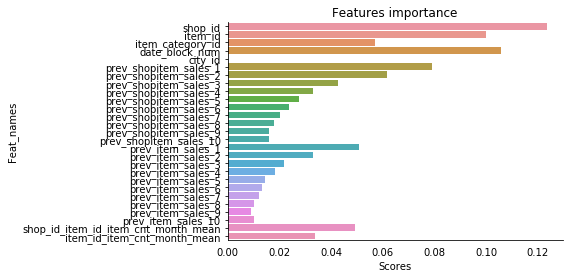

In [51]:
importance=pd.DataFrame(baseline_features[:-1], columns=["Feat_names"])
importance["Scores"]=model.feature_importances_
sns.barplot(data=importance, y="Feat_names", x="Scores", orient="h" )
plt.title("Features importance")
plt.tick_params(top='off', bottom='off', left='on', right='off', labelleft='on', labelbottom='on')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color("black")